<a href="https://colab.research.google.com/github/sami1220/sp20.ResNet_VGG/blob/main/sp20_ResNet_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint20 ResNet VGG

## 問題１　コードレビュー

・エンコーダーブロックで学習が進むにつれて次元が削減、デコーダブロックで削減された次元を復元する処理がある


・ショートカットコネクションがあり、コンボリューション層の後にinputを足す処理がある

In [ ]:
# pip install tensorflow==1.14.0
!pip install tensorflow-gpu==1.14.0

In [ ]:
pip list

In [ ]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.losses import binary_crossentropy
from keras.applications.vgg19 import VGG19, preprocess_input

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
ls

images/  masks/


In [ ]:
cd ../

/content/drive/My Drive/ResNet_VGG/competition_data/train


In [ ]:
! unzip competition_data.zip

In [ ]:
! unzip Unet/train.zip

## 【問題1】コードレビュー

事前準備でダウンロードしたコードは、転移学習を使用してセグメンテーションの精度を改善したコードです。

このコードについて、レビューを行ってください。


《視点例》


前回使用した実装とはどのように違うのか
転移学習をどのように行っているか


In [ ]:
# ・U-netのモデルと違う点


# ・評価関数が違う

## 【問題2】コードの書き換え

エンコーダーにResNetが使用されていたコードをVGGに変更してください。

In [ ]:
# train_df

,id,rle_mask
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1,3cb59a4fdc,1 5656
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3,c78c89577c,101 1
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...
...,...,...
3995,429b289e07,1 6463 6465 98 6566 97 6667 95 6768 94 6869 93...
3996,5d752d6d4a,NaN
3997,26527458de,NaN
3998,25fb3a895a,NaN


In [ ]:
# test_df

,id,rle_mask
0,3e06571ef3,1 1
1,a51b08d882,1 1
2,c32590b06f,1 1
3,15f7a047c7,1 1
4,e8827bc832,1 1
...,...,...
17995,f7b9f874cb,1 1
17996,26943026b5,1 1
17997,a5050ea371,1 1
17998,7d596c01eb,1 1


In [ ]:
# depth_df

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783
...,...,...
21995,09f1675cfb,400
21996,6947dbc4f4,804
21997,68de95fb39,605
21998,fdad2f99d8,309


In [ ]:


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

train_df = pd.read_csv('/content/drive/MyDrive/ResNet_VGG/competition_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ResNet_VGG/competition_data/sample_submission.csv')
depth_df = pd.read_csv('/content/drive/MyDrive/ResNet_VGG/competition_data/depths.csv')

# 出力
display(train_df.head())
display(test_df.head())

# depths.csvと結合
train_df = train_df.merge(depth_df, how='left', on='id')
test_df = test_df.merge(depth_df, how='left', on='id')

# 出力
display(train_df.head())
display(test_df.head())

,id,rle_mask
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1,3cb59a4fdc,1 5656
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3,c78c89577c,101 1
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...


,id,rle_mask
0,3e06571ef3,1 1
1,a51b08d882,1 1
2,c32590b06f,1 1
3,15f7a047c7,1 1
4,e8827bc832,1 1


,id,rle_mask,z
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...,312
1,3cb59a4fdc,1 5656,603
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...,687
3,c78c89577c,101 1,236
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...,805


,id,rle_mask,z
0,3e06571ef3,1 1,232
1,a51b08d882,1 1,470
2,c32590b06f,1 1,682
3,15f7a047c7,1 1,653
4,e8827bc832,1 1,103


In [ ]:
('/drive/MyDrive/ResNet_VGG/competition_data/train/images/')

'/drive/MyDrive/ResNet_VGG/competition_data/train/images/'

In [ ]:
X_train

array([None, None, None, ..., None, None, None], dtype=object)

In [ ]:
X_train = np.asarray(
    [cv2.imread('images/{}.png'.format(x), 0) for x in train_df.id.tolist()]) / 255.
y_train = np.asarray(
    [cv2.imread('masks/{}.png'.format(x), 0) for x in train_df.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


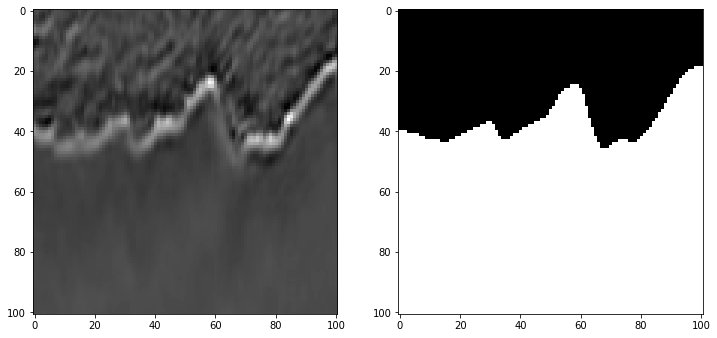

In [ ]:
# 試しに描画
random_index = np.random.randint(0, X_train.shape[0])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

In [ ]:
def compute_coverage(df, masks):
    """領域割合の計算とクラスの付与
    Parameters
    ------------
    train_df : df
    masks : セグメンテーション画像
    """
    def coverage_to_class(val):
        """領域割合からクラスを付与
        val : セグメンテーション領域の割合
        """
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # セグメンテーション領域の割合
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # 何割が覆われているかで、0~10までのクラスを与える
    df['coverage_class'] = df.coverage.map(coverage_to_class)

    return df

# 関数実行
compute_coverage(train_df, y_train)

# 出力
display(train_df)

,id,rle_mask,z,coverage,coverage_class
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...,312,0.530928,6
1,3cb59a4fdc,1 5656,603,0.554455,6
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...,687,0.481717,5
3,c78c89577c,101 1,236,0.000098,1
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...,805,0.078718,1
...,...,...,...,...,...
3995,429b289e07,1 6463 6465 98 6566 97 6667 95 6768 94 6869 93...,562,0.890991,9
3996,5d752d6d4a,NaN,235,0.000000,0
3997,26527458de,NaN,587,0.000000,0
3998,25fb3a895a,NaN,468,0.000000,0


In [ ]:
def create_depth_abs_channels(image_tensor):
    """3チャンネルに拡張
    """
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)
    return image_tensor

# 3チャンネルに拡張
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# ResNetのデフォルトのサイズに合わせるため、224,224にリサイズ
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

# train_test_splitでもよさそうだが、、、
kfold = StratifiedKFold(n_splits=5)
for train_index, valid_index in kfold.split(train_df.id.values, train_df.coverage_class.values):
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    break
    
# セグメンテーションの正解データの形整える
y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_resized.shape, y_resized.shape)
print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(4000, 224, 224, 3) (4000, 224, 224)
(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


# 損失関数など定義

In [ ]:
def dice_loss(y_true, y_pred):
    """dice損失の計算
    DICE損失参考：https://qiita.com/ppza53893/items/8090322792e1c7f81e57
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    """binary_crossentropyとdice加算した統合損失
    """
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    """IOUの計算
    IOU参考：https://www.sigfoss.com/developer_blog/detail?actual_object_id=147
    A : 正解データ
    B : 0.5より大きければ1 0.5以下なら0に変換された予測領域
    """
    # バッチ数取得
    batch_size = A.shape[0]
    # 最終的な評価指標
    metric = 0.0
    # バッチ数でループ
    for batch in range(batch_size):
        # 引数A,Bより配列抽出
        t, p = A[batch], B[batch]
        # 正しい領域のピクセル
        true = np.sum(t) 
        # 推定した領域のピクセル
        pred = np.sum(p) 
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
            
        # 正しく領域と推定されたピクセル
        intersection = np.sum(t * p) 
        
        # IOU計算
        union = true + pred - intersection
        iou = intersection / union
        
        # 実際のIOUに近似
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        # 最終的な評価指標に加算
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

In [ ]:
# 入力のshape定義
input_size = (224, 224, 3)

In [ ]:
# ライブラリのimportの際に読み込んでおいたResNet50をインスタンス化
# 全結合層を場外する指定：include_top=False
base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

# デコーダーブロックの定義

エンコーダーとデコーダーに関して、下記参照

https://atmarkit.itmedia.co.jp/ait/articles/2007/10/news024.html

In [ ]:
def decoder_block_simple(layer_name, block_name,num_filters=32,conv_dim=(3, 3)):
    """デコーダーブロック
    Parameters
    ------------
    layer_name : 前の層のインスタンス
    block_name : この層のベースとなる名前
    num_filters : フィルター数
    conv_dim : フィルターサイズ
    """
    # 畳み込み
    x_dec = Conv2D(num_filters, conv_dim,padding='same',name='{}_conv'.format(block_name))(layer_name)
    # バッチ正規化
    x_dec = BatchNormalization(name='{}_bn'.format(block_name))(x_dec)
    # 活性化関数（PReLU）
    x_dec = PReLU(name='{}_activation'.format(block_name))(x_dec)
    return x_dec


def decoder_block_bottleneck(layer_name, block_name,num_filters=32,conv_dim=(3, 3),dropout_frac=0.2):
    """複雑なデコーダーブロック
    Parameters
    ------------
    layer_name : 前の層のインスタンス
    block_name : この層のベースとなる名前
    num_filters : フィルター数
    conv_dim : フィルターサイズ
    dropout_frac : ドロップアウト率
    """
    x_dec = Conv2D(num_filters, conv_dim,padding='same',name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(num_filters // 2, conv_dim,padding='same',name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(num_filters, conv_dim,padding='same',name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])
    return x_dec2

In [ ]:
def unet_resnet(input_size, decoder_block,weights='imagenet',loss_func='binary_crossentropy',metrics_list=[my_iou_metric],use_lovash=False):
    """resnetを模倣したunet構造のネットワーク
    Parameters
    ------------
    input_size    : 入力サイズ
    decoder_block : デコーダーブロック
    weights       : 重みの初期値　        default:imagenet,
    loss_func     : 損失関数　            default:binary_crossentropy
    metrics_list  : 指標一覧　            default:[my_iou_metric]
    use_lovash    : lavash使うか          default:False
    """
    # resnet50のベースモデル
    base_model = ResNet50(input_shape=input_size, include_top=False, weights=weights)
    
    # base_modelの中間層を抽出
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40
    
    # 流れ
    # ①encoder5の出力をデコーダーブロックに渡す
    # ②encoder5と①を結合
    center = decoder_block(encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # 流れ
    # ①concat5,の出力をデコーダーブロックに渡す
    # ②①をupsamplingする
    # ③encoder4と②を結合する
    # ①～③を繰り返し
    decoder4 = decoder_block(concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # 再度upsamplingする
    output = UpSampling2D()(concat1)
    # デコーダーブロックに通す
    output = decoder_block(output, 'decoder_output', num_filters=32)
    # 畳込み
    output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        # lovash使う場合は、sigmoid関数に通しておく
        output = Activation('sigmoid')(output)
        
    
    # モデルの結合
    model = Model(base_model.input, output)
    # 損失・最適化手法・指標一覧を与えて、コンパイル
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)
    
    # モデルを返す
    return model

## 学習

In [ ]:
# モデルの定義
model = unet_resnet(input_size, decoder_block_bottleneck, weights='imagenet',loss_func=bce_dice_loss, metrics_list=[my_iou_metric],use_lovash=False)
print(model.summary())

/usr/local/lib/python3.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLaye

In [ ]:
# 学習回数
EPOCHS = 2
# バッチ数
BATCH_NUM = 16

# モデルの保存設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5',
    monitor='val_my_iou_metric',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
# 学習率の減衰設定
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1
)


# 学習の実行と学習過程の取得
history = model.fit(
    X_tr, y_tr,
    validation_data=[X_val, y_val], 
    epochs=EPOCHS,
    batch_size=BATCH_NUM,
    callbacks=[model_checkpoint,reduce_lr], 
    verbose=1
)


Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 266s 83ms/step - loss: 0.7764 - my_iou_metric: 0.3739 - val_loss: 241.0702 - val_my_iou_metric: 0.1321

Epoch 00001: val_my_iou_metric improved from -inf to 0.13213, saving model to unet_resnet.h5
Epoch 2/2
3200/3200 [==============================] - 237s 74ms/step - loss: 0.5947 - my_iou_metric: 0.5072 - val_loss: 2.7589 - val_my_iou_metric: 6.2500e-04

Epoch 00002: val_my_iou_metric did not improve from 0.13213


推定

In [ ]:
# 推定
val_preds = model.predict(X_val, batch_size=16)

# 元の大きさにリサイズ
y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

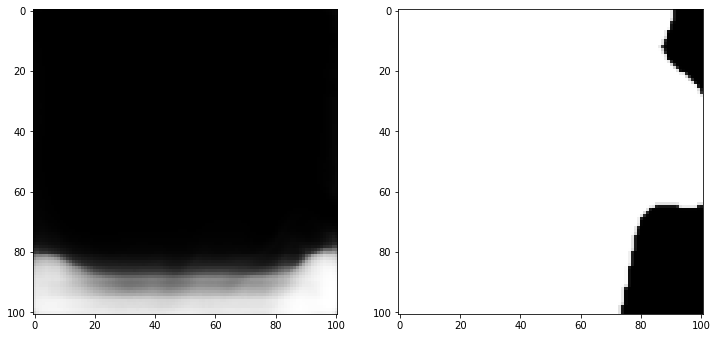

In [ ]:
# 描画
random_index = np.random.randint(0, y_val_pred.shape[0])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y_val_pred[random_index], cmap='gray')
ax[1].imshow(y_val_true[random_index], cmap='gray')

## 問題２　コードの書き換え

VGGに対応させる

In [ ]:
def unet_vgg(input_size, decoder_block,weights='imagenet',loss_func='binary_crossentropy',metrics_list=[my_iou_metric],use_lovash=False):
    #  ベースモデルにVGG
    base_model = VGG19(input_shape=input_size, include_top=False,weights=weights)
    
    encoder1 = base_model.get_layer('block1_conv2').output # (224,224,64)
    encoder2 = base_model.get_layer('block2_conv2').output # (112,112,228)
    encoder3 = base_model.get_layer('block3_conv4').output # (56,56,256)
    encoder4 = base_model.get_layer('block4_conv4').output # (28,28,512)
    encoder5 = base_model.get_layer('block5_conv4').output # (14,14,512)


    center = decoder_block(encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1) # (14,14,1024)

    decoder4 = decoder_block(concat5, 'decoder4', num_filters=256) 
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1) 
    
    decoder3 = decoder_block(concat4, 'decoder3', num_filters=128) 
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1) 

    decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)
    
    output = decoder_block(concat1, 'decoder_output', num_filters=32)
    output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

In [ ]:
# モデルの定義
model = unet_vgg(input_size, decoder_block_bottleneck, weights='imagenet',loss_func=bce_dice_loss, metrics_list=[my_iou_metric],use_lovash=False)
print(model.summary())

80142336/80134624 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________

In [ ]:
tf.test.gpu_device_name()
# 学習回数
EPOCHS = 2
# バッチ数
BATCH_NUM = 16

# モデルの保存設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5',
    monitor='val_my_iou_metric',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
# 学習率の減衰設定
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1
)


# 学習の実行と学習過程の取得
history = model.fit(
    X_tr, y_tr,
    validation_data=[X_val, y_val], 
    epochs=EPOCHS,
    batch_size=BATCH_NUM,
    callbacks=[model_checkpoint,reduce_lr], 
    verbose=1
)

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 285s 89ms/step - loss: 0.9331 - my_iou_metric: 0.1375 - val_loss: 1.2443 - val_my_iou_metric: 0.1637

Epoch 00001: val_my_iou_metric improved from -inf to 0.16375, saving model to unet_resnet.h5
Epoch 2/2
3200/3200 [==============================] - 271s 85ms/step - loss: 0.7657 - my_iou_metric: 0.1958 - val_loss: 1.4249 - val_my_iou_metric: 0.2212

Epoch 00002: val_my_iou_metric improved from 0.16375 to 0.22125, saving model to unet_resnet.h5


In [ ]:
# 推定
pred = model.predict(X_val, batch_size=16)

# 元の大きさにリサイズ
y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), pred)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

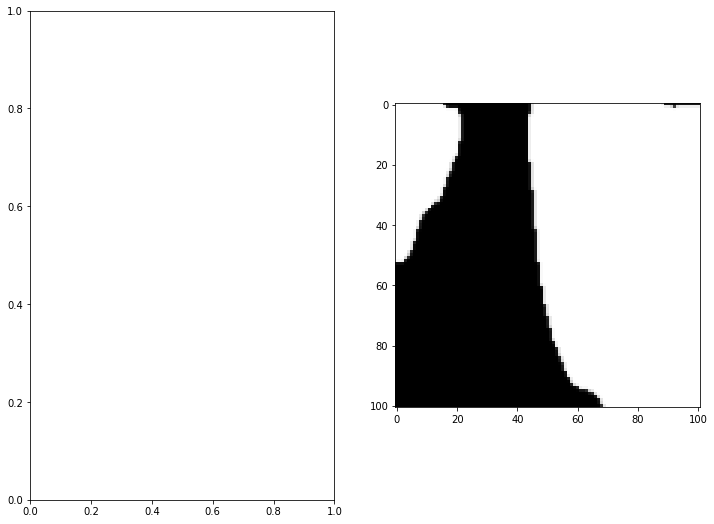

In [ ]:
# 描画
random_index = np.random.randint(0, pred.shape[0])
fig, ax = plt.subplots(1, 2)
# ax[0].imshow(pred[random_index], cmap='gray')
ax[1].imshow(y_val_true[random_index], cmap='gray')

## 問題3　学習　推定

### ●ResNet


Train on 3200 samples, validate on 800 samples

Epoch 1/2
3200/3200 [==============================] - 266s 83ms/step - loss: 0.7764 - my_iou_metric: 0.3739 - val_loss: 241.0702 - val_my_iou_metric: 0.1321

Epoch 00001: val_my_iou_metric improved from -inf to 0.13213, saving model to unet_resnet.h5
Epoch 2/2
3200/3200 [==============================] - 237s 74ms/step - loss: 0.5947 - my_iou_metric: 0.5072 - val_loss: 2.7589 - val_my_iou_metric: 6.2500e-04


Epoch 00002: val_my_iou_metric did not improve from 0.13213

------------------------------------------------

###  ●VGG
Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 285s 89ms/step - loss: 0.9331 - my_iou_metric: 0.1375 - val_loss: 1.2443 - val_my_iou_metric: 0.1637

Epoch 00001: val_my_iou_metric improved from -inf to 0.16375, saving model to unet_resnet.h5

Epoch 2/2
3200/3200 [==============================] - 271s 85ms/step - loss: 0.7657 - my_iou_metric: 0.1958 - val_loss: 1.4249 - val_my_iou_metric: 0.2212


Epoch 00002: val_my_iou_metric improved from 0.16375 to 0.22125, saving model to unet_resnet.h5





VGGの方がlossが低い